Loading dataset. It might take a while ...
0.0897679328918457
Loading IRs ...


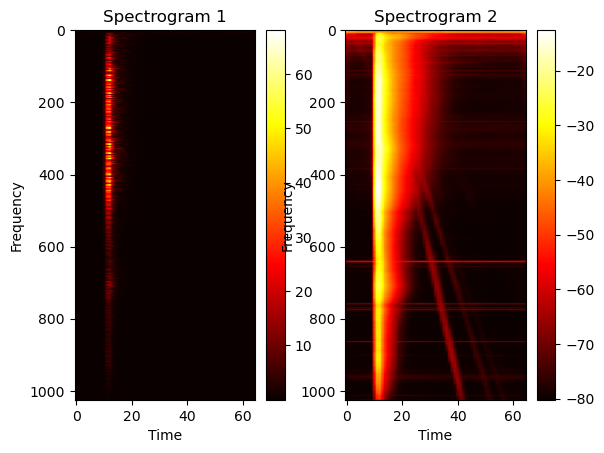

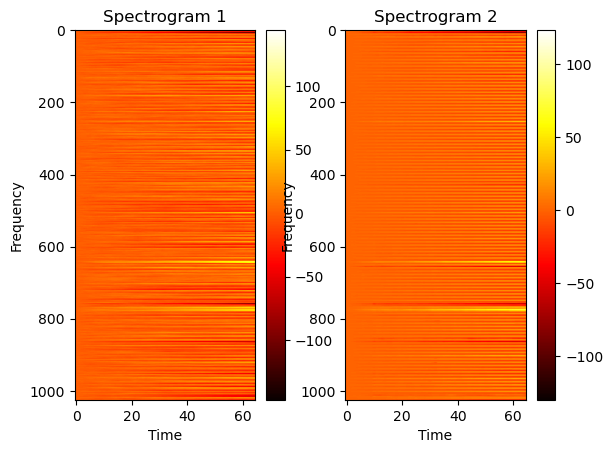

In [3]:
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import argparse
import os
import tempfile
import math
import time
from pathlib import Path
import librosa

from network import NAF
from sound_loader import sound_samples
from utils.irutilities import loadIR

# Device selection
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset
print('Loading dataset. It might take a while ...')
dataset = sound_samples(num_samples=20)

# Get one sample to compare to
s = 1
m = 100

sample = dataset.spectrograms[s,m,:]
sample_phase = dataset.phases[s,m,:]
src = torch.tensor(dataset.posSrc[s, :]).unsqueeze(1).to(device)
mic = torch.tensor(dataset.posMic[m, :]).unsqueeze(1).to(device)

# Load NAF with selected configuration
net = NAF(input_dim = 288, min_xy=dataset.min_pos[:2], max_xy=dataset.max_pos[:2]).to(device)
state_dict = torch.load('saved/net_20230905_123214_loss_0.0013.pth')
net.load_state_dict(state_dict)
net.eval()

start_time = time.time()
out = net.spectrogram_at(src, mic).cpu()
exec_time = time.time() - start_time
print(exec_time)
out[:,:,0] = (out[:,:,0] * dataset.std) + dataset.mean
out[:,:,1] = out[:,:,1] * 180

# Testing spectrogram things
path = Path('mesh_rir/S32-M441_npy/')
print('Loading IRs ...')
posMic, posSrc, ir = loadIR(path)
stft = librosa.stft(ir[s,m,:], n_fft=2048, hop_length=512)
sample = np.abs(stft)
phase = np.angle(stft)
sample_phase = np.unwrap(phase)

# First Image
plt.subplot(1, 2, 1)
plt.imshow(sample, cmap='hot', aspect='auto')
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectrogram 1')

# Second Image
plt.subplot(1, 2, 2)
plt.imshow(out.cpu()[:,:,0], cmap='hot', aspect='auto')
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectrogram 2')

plt.show()

# First Image
plt.subplot(1, 2, 1)
plt.imshow(sample_phase, cmap='hot', aspect='auto')
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectrogram 1')

# Second Image
plt.subplot(1, 2, 2)
plt.imshow(out.cpu()[:,:,1], cmap='hot', aspect='auto')
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectrogram 2')

plt.show()

In [ ]:
import sys
sys.path.append("utils/")
import irutilities as irutil
from pathlib import Path
import librosa

path = Path('mesh_rir/S32-M441_npy/')
print('Loading IRs ...')
posMic, posSrc, ir = irutil.loadIR(path)

# Convert the magnitude spectrogram back to linear scale
#spectrogram = librosa.db_to_amplitude(out.cpu().numpy())

# Reconstruct the audio signal using the inverse STFT
#reconstructed_audio =  librosa.istft(out[:,:,0].numpy() * np.exp(1j * out[:,:,1].numpy()), hop_length=512)

uno = librosa.istft(sample * np.exp(-1j * sample_phase), hop_length=512)



time = np.arange(0, len(ir[0,0,:])) / 48000

# Plot the audio waveform
plt.figure(figsize=(10, 4))
#plt.plot(time, reconstructed_audio, linewidth=0.5)
#plt.plot(time, uno, linewidth=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Audio Waveform')
plt.grid(True)
plt.show()

In [4]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

audio_file = ir[s,m:]
y = ir[s,m,:]
sr = 48000

stft = librosa.stft(y, n_fft=2048, hop_length=512)

magnitude = np.abs(stft)
phase = np.angle(stft)

phase_unwrapped = np.unwrap(phase)

magnitude = dataset.spectrograms[s,m,:]
magnitude = librosa.db_to_amplitude(magnitude)
phase_unwrapped = dataset.phases[s,m,:]

complex_spectrogram = magnitude * np.exp(1j * phase_unwrapped)

signal = librosa.istft(complex_spectrogram, hop_length=512)

time = np.arange(0, len(signal)) / sr

plt.figure(figsize=(10, 4))
plt.plot(time, signal)
plt.title("Reconstructed Audio Amplitude Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(time, y)
plt.title("Reconstructed Audio Amplitude Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

TypeError: 'function' object is not subscriptable